With standard python , we can only process data that can fit into our computer.While this has served the purpose for most of
the problems we encounter at my work place,it has severe limitation in dealing with data coming from IOT portals. The IOT data
is so huge that it needs to be run distributed across different machines and further this purpose, we need Spark, a distributed
computing frame work written in Scala. While Scala brings this amazing abality of paralell processing, the visualisation and wrangling capability seen in Pandas, Matplotlib and Seaborn are missing. To bridge this gap we have pyspark , which integrates both the speed of spark and wrangling capabilities of pandas.

Since all the problems I solved at work in pyspark are  proprietary, I am taking a publicly available data set to dispay various functions available in spark.

** Problem Statement **

The data set is taken from USA census.Each row in the data set contains record for an individual. The data consists of various demographic details such as age, gender,ethnicity,income etc.The goal is to design an alogorithm that can predict if the income of an individual is going to be above 50K or not.

In [167]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="talk",style="whitegrid",rc={'axes.grid':False,'axes.labelsize':15,"axes.labelweight":'bold',"xtick.labelsize":12,"ytick.labelsize":12})
%matplotlib inline

In [168]:
import math
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.functions import col, udf

In [345]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

In [169]:
spark=SparkSession.builder.master("local[*]").appName("Income_Prediction").getOrCreate()

In [170]:
spark

In [171]:
sc=spark.sparkContext

In [172]:
sc

<SparkContext master=local[*] appName=Income_Prediction>

In [173]:
sqlContext=SQLContext(sc)

The Data reader in spark can estimate datatypess sampling over columns.However, it will take time to do sampling and arrive at
an appropriate Data Type. It is advisable to specify Schema before hand if all the data types are known.

In [174]:
#Defining schema for data 
schema = StructType([
    StructField("age", IntegerType(), nullable=True),
    StructField("workclass", StringType(), nullable=True),
    StructField("fnlgwt", DoubleType(), nullable=True),
    StructField("education", StringType(), nullable=True),
    StructField("education_num", DoubleType(), nullable=True),
    StructField("marital_status", StringType(), nullable=True),
    StructField("occupation", StringType(), nullable=True),
    StructField("relationship", StringType(), nullable=True),
    StructField("race", StringType(), nullable=True),
    StructField("sex", StringType(), nullable=True),
    StructField("capital_gain", DoubleType(), nullable=True),
    StructField("capital_loss", DoubleType(), nullable=True),
    StructField("hours_per_week", DoubleType(), nullable=True),
    StructField("native_country", StringType(), nullable=True),
    StructField("income", StringType(), nullable=True)]
)

In [175]:
df_train=spark.read.csv(path='Train.csv',schema=schema,ignoreLeadingWhiteSpace=True, ignoreTrailingWhiteSpace=True).cache()

In [176]:
df_train.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlgwt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)



In [177]:
df_train.limit(10).toPandas()

,age,workclass,fnlgwt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
5,37,Private,284582.0,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K
6,49,Private,160187.0,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,<=50K
7,52,Self-emp-not-inc,209642.0,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
8,31,Private,45781.0,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K
9,42,Private,159449.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K


In [178]:
df_test=spark.read.csv(path='Test.csv',schema=schema,ignoreLeadingWhiteSpace=True, ignoreTrailingWhiteSpace=True).cache()

In [179]:
df_test.limit(5).toPandas()

,age,workclass,fnlgwt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
1,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
2,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
3,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.
4,18,?,103497.0,Some-college,10.0,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K.


**Data Exploration** 

In [180]:
print("No of Records in the Training Data Set: %d"%(df_train.count()))
print("No of Records in the Test Data Set: %d"%(df_test.count()))

No of Records in the Training Data Set: 32561
No of Records in the Test Data Set: 16281


In [181]:
df_train.groupby("income").count().withColumn("Percentage",round(col('count')/df_train.count(),2)).toPandas()

,income,count,Percentage
0,<=50K,24720,0.76
1,>50K,7841,0.24


In [182]:
df_test.groupby("income").count().withColumn("Percentage",round(col('count')/df_test.count(),2)).toPandas()

,income,count,Percentage
0,<=50K.,12435,0.76
1,>50K.,3846,0.24


The proportion of labels in both the train and test data sets is the same.However, the proportion of each class is not balanced.
This problem mught need some special methods to solve this imbalance issue. 

In [183]:
df_train=df_train.withColumn("income_Target",when(df_train.income=='>50K',1).otherwise(0))

In [184]:
df_train.toPandas().head(10)

,age,workclass,fnlgwt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,income_Target
0,39,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K,0
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K,0
2,38,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K,0
3,53,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K,0
4,28,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K,0
5,37,Private,284582.0,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K,0
6,49,Private,160187.0,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,<=50K,0
7,52,Self-emp-not-inc,209642.0,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K,1
8,31,Private,45781.0,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K,1
9,42,Private,159449.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K,1


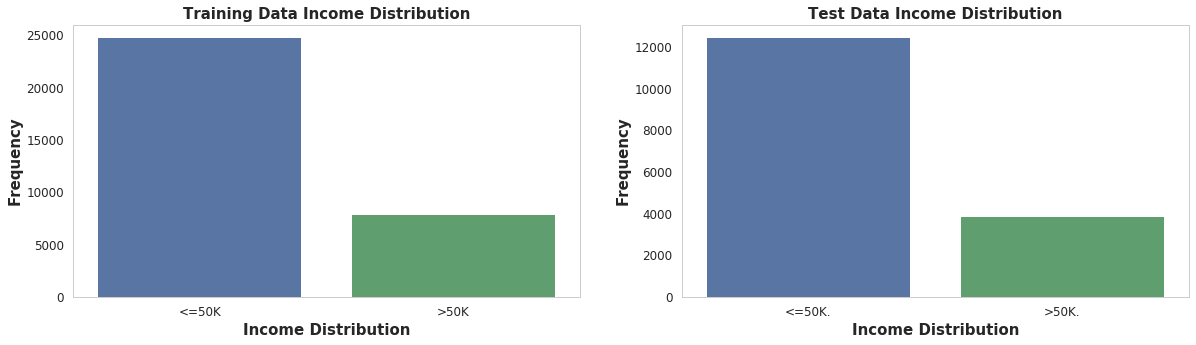

In [185]:
S=df_train.select("income").toPandas()
S2=df_test.select("income").toPandas()
fig1 =plt.figure(figsize=(20,5))
ax1=fig1.add_subplot(1,2,1)
ax2=fig1.add_subplot(1,2,2)
sns.countplot(x="income",data=S,ax=ax1)
ax1.set_xlabel("Income Distribution",fontsize=15,weight='bold')
ax1.set_ylabel("Frequency",fontsize=15,weight='bold')
ax1.set_title("Training Data Income Distribution",fontsize=15,weight='bold')
ax1.tick_params(labelsize=12)
sns.countplot(x="income",data=S2,ax=ax2)
ax2.set_xlabel("Income Distribution",fontsize=15,weight='bold')
ax2.set_ylabel("Frequency",fontsize=15,weight='bold')
ax2.set_title("Test Data Income Distribution",fontsize=15,weight='bold')
ax2.tick_params(labelsize=12)

** Age **

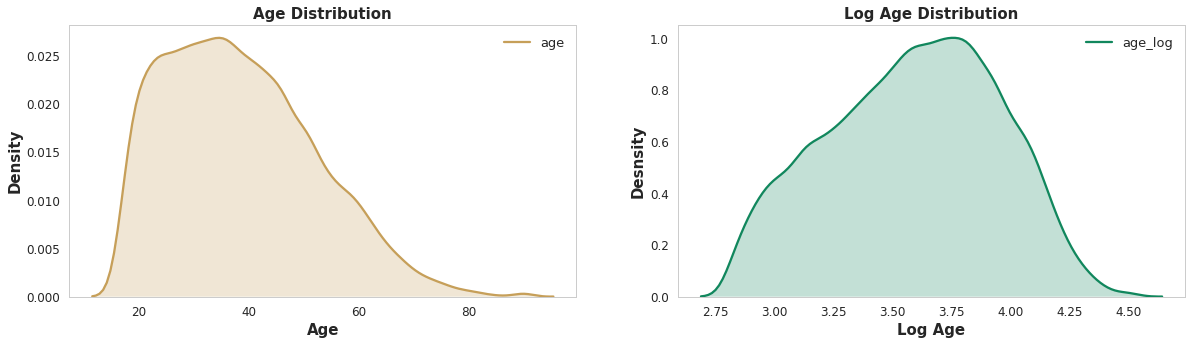

In [186]:
fig1=plt.figure(figsize=(20,5))
ax1=fig1.add_subplot(1,2,1)
S_age=df_train.select("age").toPandas()
sns.kdeplot(S_age['age'],color=sns.xkcd_rgb["camel"],ax=ax1,shade=True)
ax1.set_xlabel("Age",fontsize=15,weight='bold')
ax1.set_ylabel("Density",fontsize=15,weight='bold')
ax1.set_title("Age Distribution",fontsize=15,weight='bold')
ax1.tick_params(labelsize=12)
ax2=fig1.add_subplot(1,2,2)
S_age2=df_train.select(log("age").alias("age_log")).toPandas()
sns.kdeplot(S_age2['age_log'],color=sns.xkcd_rgb["dark sea green"],ax=ax2,shade=True)
ax2.set_xlabel("Log Age",fontsize=15,weight='bold')
ax2.set_ylabel("Desnsity",fontsize=15,weight='bold')
ax2.set_title("Log Age Distribution",fontsize=15,weight='bold')
ax2.tick_params(labelsize=12)

Age distribution is right tailed.Taking a logarithm for age is making it more close to normal. Monotonic transformations on 
predictive features doesn't have much impact on improving accuracy for complex algortihms such as Xgboost, but it will help in improving accuracy of linear models.

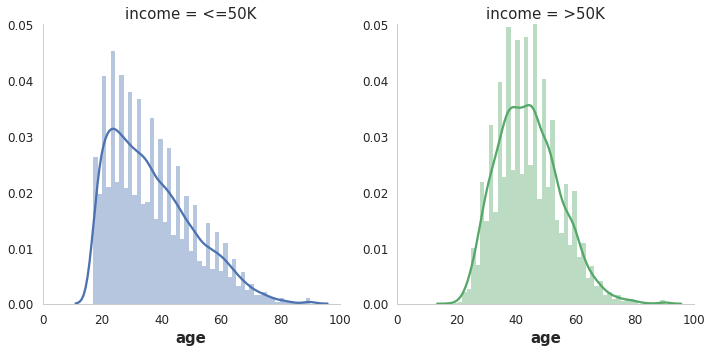

In [187]:
S_age3=df_train.select("age","income").toPandas()
g1=sns.FacetGrid(S_age3,col="income",size=5,hue='income',sharex=True,sharey=True,xlim=(0,100),ylim=(0,0.05))
g1.map(sns.distplot,"age")

Age group of 40 to 50 has more people earning greater than 50K than age group 20 to 30. Age group 20 to 30 is at start of it's
career and generally earns less than 40 to 50, which is mid career range. This increase in proportion can be inferred in age group 50 to 60 also.

** Work class **

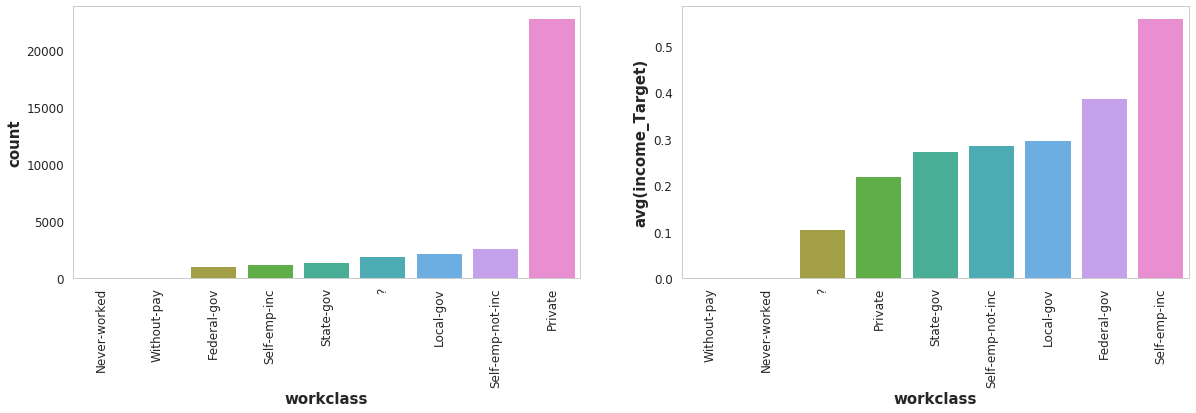

In [188]:
fig3=plt.figure(figsize=(20,5))
ax1=fig3.add_subplot(1,2,1)
df_tr_w=df_train.select("workclass").groupby("workclass").count().sort(asc("count")).toPandas()
sns.barplot(x="workclass",y="count",data=df_tr_w,ax=ax1)
df_tr_w_i=df_train.select("workclass").groupby("workclass")
ax2=fig3.add_subplot(1,2,2)
df_tr_wi=df_train.groupby("workclass").mean("income_Target").sort(asc("avg(income_Target)")).toPandas()
sns.barplot(x="workclass",y="avg(income_Target)",data=df_tr_wi,ax=ax2)
ax1.tick_params(axis='x',rotation=90)
ax2.tick_params(axis='x',rotation=90)

Private sector is dominating the over all population and so the population average is close to it's average.Self -emp-inc has almost 50% of people earning more than 50K

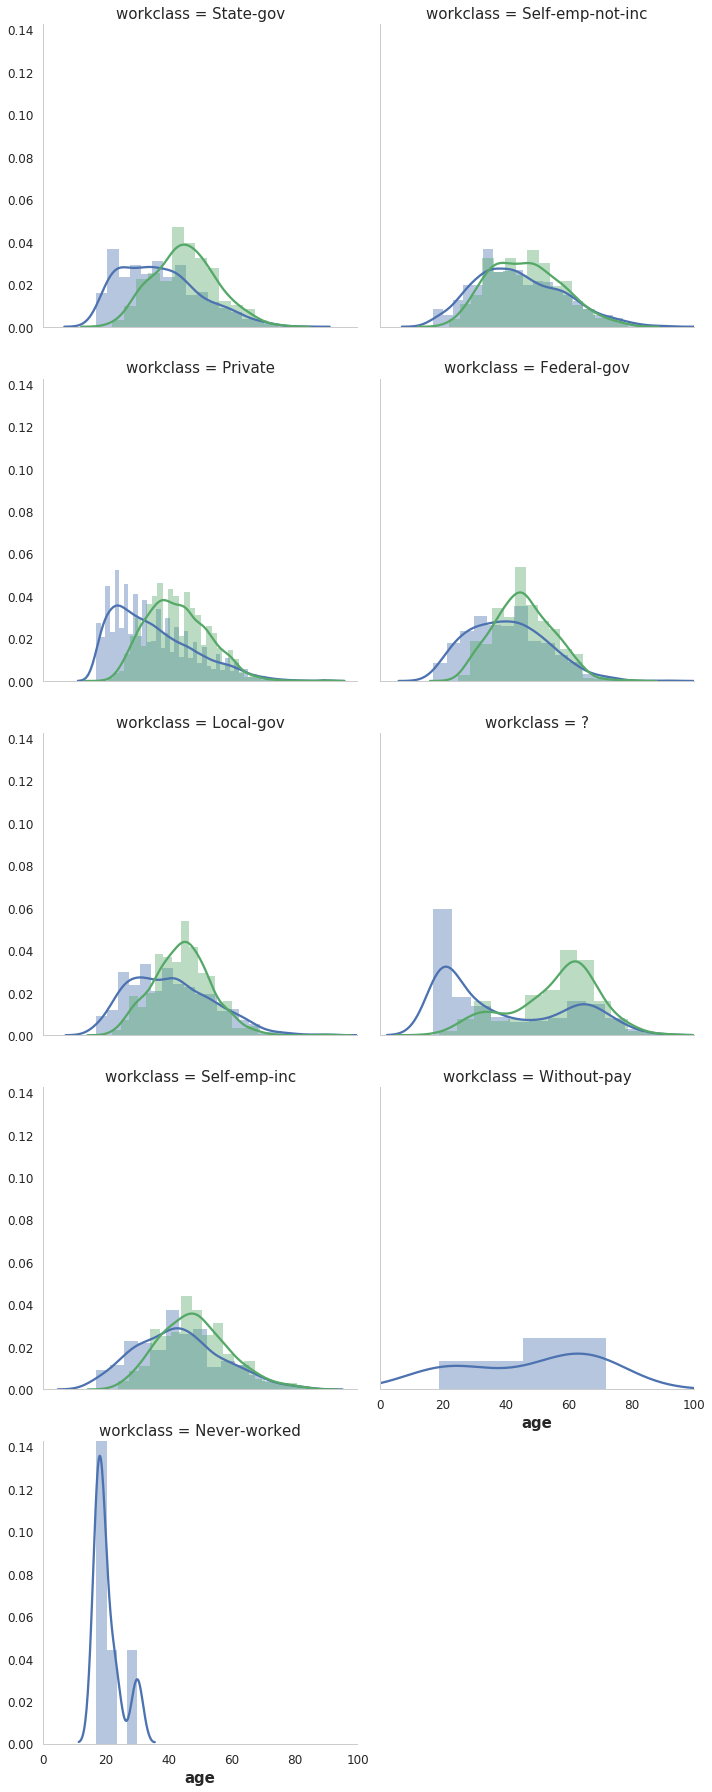

In [198]:
S_age4=df_train.select("age","income","workclass").toPandas()
g1=sns.FacetGrid(S_age4,col="workclass",size=5,hue='income',sharex=True,sharey=True,xlim=(0,100),ylim=(0,0.05),col_wrap=2)
g1.map(sns.distplot,"age")

Age has an impact on earning capacity. Age group 20 to 30 has lower proportion earning more than 50K. It proportion peaks for
age group 35 to 45. 
Working class has an effect on this proportion also.Working class never work and without pay has zero pay above 50k irrespective
of age.This observation is self explanatory.
For working class "?", the proportion has it's max at age 60.Also, the proportion of age group 35 to 45 is less compared other 
working classes.

** Education **

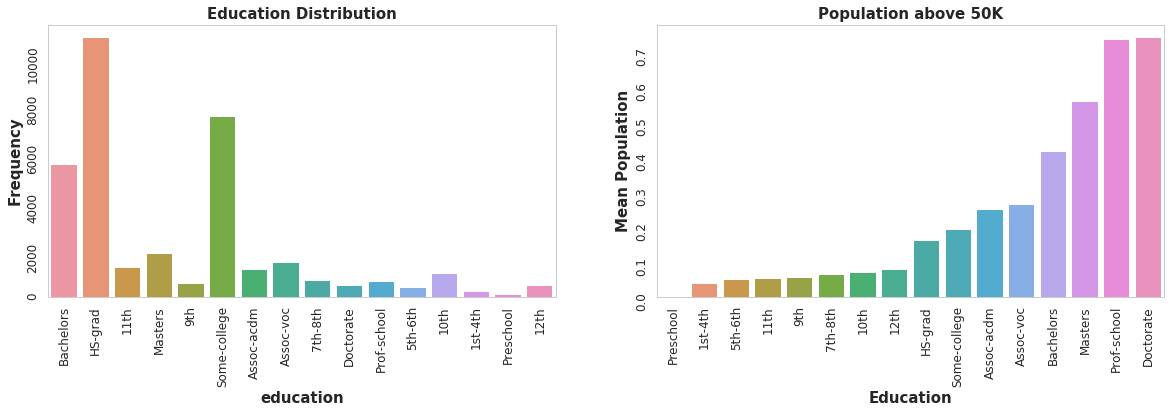

In [202]:
fig4=plt.figure(figsize=(20,5))
ax1=fig4.add_subplot(1,2,1)
df_tr_e=df_train.select("education").toPandas()
sns.countplot(x="education",data=df_tr_e,ax=ax1)
ax1.set_xlabel("education",fontsize=15,weight='bold')
ax1.set_ylabel("Frequency",fontsize=15,weight='bold')
ax1.set_title("Education Distribution",fontsize=15,weight='bold')
ax1.tick_params(labelsize=12,rotation=90)
ax2=fig4.add_subplot(1,2,2)
df_tr_ei=df_train.groupby("education").mean("income_Target").sort(asc("avg(income_Target)")).toPandas()
sns.barplot(x="education",y="avg(income_Target)",ax=ax2,data=df_tr_ei)
ax2.set_xlabel("Education",fontsize=15,weight='bold')
ax2.set_ylabel("Mean Population",fontsize=15,weight='bold')
ax2.set_title("Population above 50K",fontsize=15,weight='bold')
ax2.tick_params(labelsize=12,rotation=90)

Bachelors, Masters,Profschool,Doctorate has greater proportion of people earning more than 50K than the data average. Also,as the education level is increasing, the proportionf of people earning more than 50K is also increasing. Finally, education is helping :-)

High school grads are close to 30% , meaning most of the people are dropping out after highschool. Bachelors is 50% of highschool grads . There is significant amount of people attending some college and after bachelors the number  is falling very quickly.

Text(0.5,1,u'Earning Potential: Education & Workclass Impact')

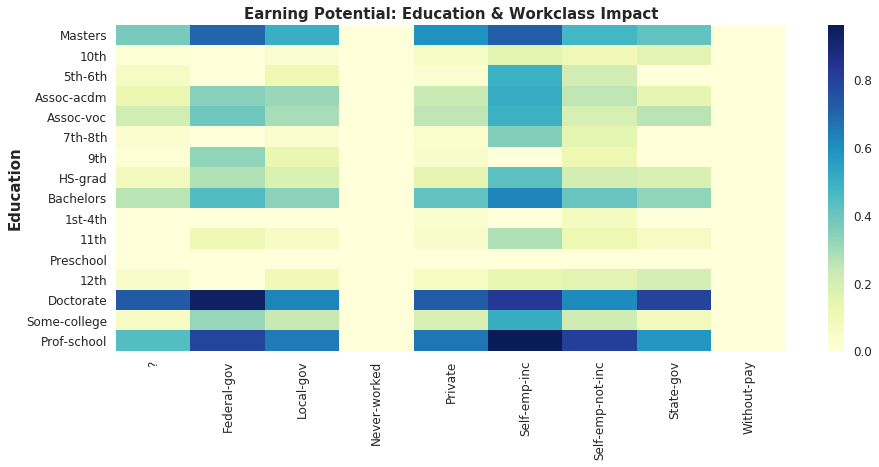

In [222]:
fig5=plt.figure(figsize=(15,6))
ax1=fig5.add_subplot(1,1,1)
df_ew=df_train.groupby("Education").pivot("workclass").mean("income_Target").toPandas()
df_ew.replace(np.NaN,0,inplace=True)
df_ew.set_index("Education",inplace=True)
sns.heatmap(df_ew,ax=ax1,cmap="YlGnBu")
ax1.set_title("Earning Potential: Education & Workclass Impact",fontsize=15,weight='bold')

Doctorates working on federal government has the highest proportion of people earning above 50K. Prof-school working in self-emp-inc
also has the similar proportion.

Text(0.5,1,u'Working class spread across work class')

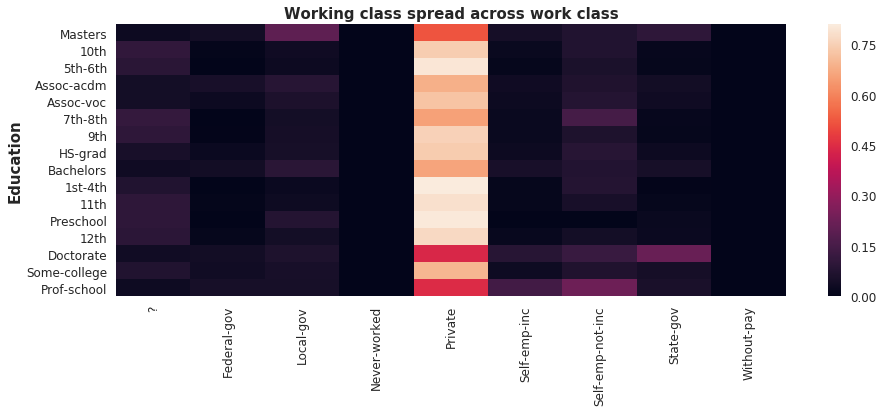

In [247]:
fig6=plt.figure(figsize=(15,5))
ax1=fig6.add_subplot(1,1,1)
df_ew2=df_ew1.apply(lambda x :x/x.sum(),axis=1)
sns.heatmap(df_ew2,ax=ax1)
ax1.set_title("Working class spread across work class",fontsize=15,weight='bold')

irrespective of education back ground major chunk of each education category is moving to private sector.

Text(0.5,1,u'work class spread across education')

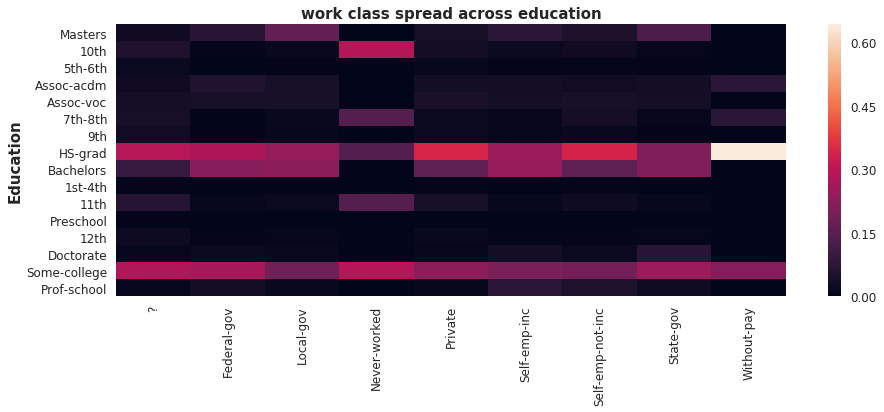

In [248]:
fig7=plt.figure(figsize=(15,5))
ax1=fig7.add_subplot(1,1,1)
df_ew2=df_ew1.apply(lambda x :x/x.sum(),axis=0)
sns.heatmap(df_ew2,ax=ax1)
ax1.set_title("work class spread across education",fontsize=15,weight='bold')

Doctorates are minority in all the work classes. 

Hs grad and some college has major representation in any working class

Never worked has significant proportion of people from 10th class

Without pay has significant proportion of people from HS-grad

** Years of Education **

Years of education is an indication of level of education. In general, a Phd will have and average of 22 years compared to 12 
years of High school graduate. Also, the earning potential of Phd is significantly greater than ahigh school graduate, with some
exceptions.

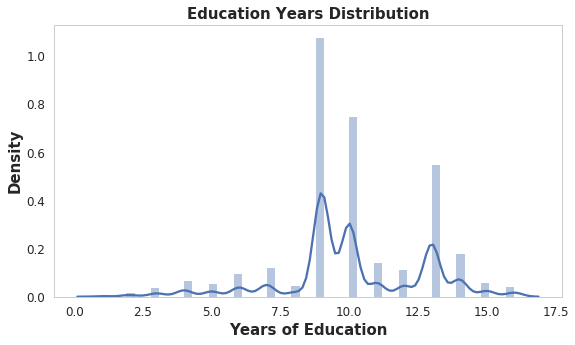

In [251]:
fig8=plt.figure(figsize=(20,5))
ax1=fig8.add_subplot(1,2,1)
df_ye=df_train.select("education_num").toPandas()
sns.distplot(df_ye["education_num"])
ax1.set_xlabel("Years of Education",fontsize=15,weight='bold')
ax1.set_ylabel("Density",fontsize=15,weight='bold')
ax1.set_title("Education Years Distribution",fontsize=15,weight='bold')
ax1.tick_params(labelsize=12)

Years of education corresponds to education level. The peaks we see can be correlated with Highschool, some college and bachelors. 

** Martial Status **

In [253]:
df_m=df_train.select("marital_status","income_Target").groupby("marital_status").mean("income_Target").toPandas()
df_m

,marital_status,avg(income_Target)
0,Separated,0.064390
1,Never-married,0.045961
2,Married-spouse-absent,0.081340
3,Divorced,0.104209
4,Widowed,0.085599
5,Married-AF-spouse,0.434783
6,Married-civ-spouse,0.446848


Of Married people close to 40% have income more than 50K. This percentage is very high compared to other categories.

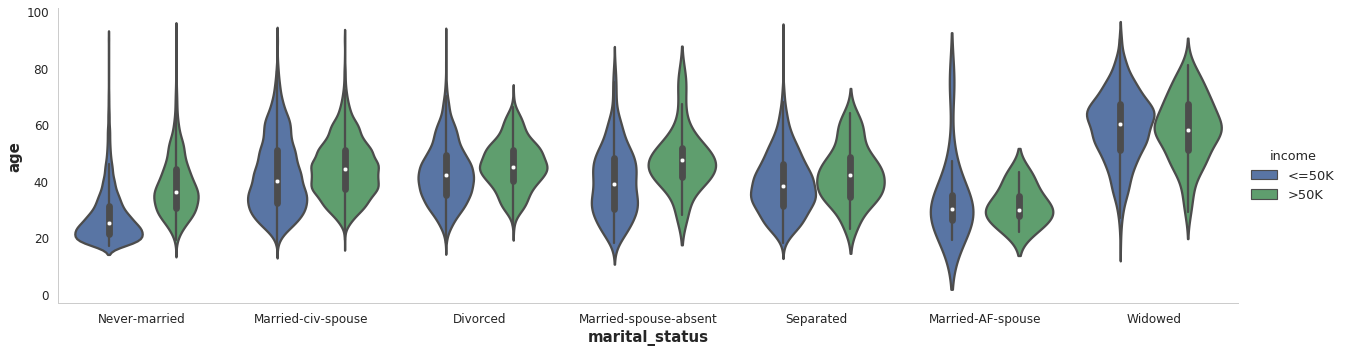

In [268]:
df_m1=df_train.select("marital_status","income","age").toPandas()
sns.factorplot(x='marital_status',y="age",hue="income",data=df_m1,kind="violin",size=5,aspect=3.5)

In all the above plots, except Married-AF spouse and widowed, the peak density for income>50k is at higher age than that of income<50K.

**Occupation**

Occupation will have significant impact on income. Some occupation such as Doctor, Engineer command higher incomes compared
to blue collar jobs. So,occupation will be a very good predictive feature for income.

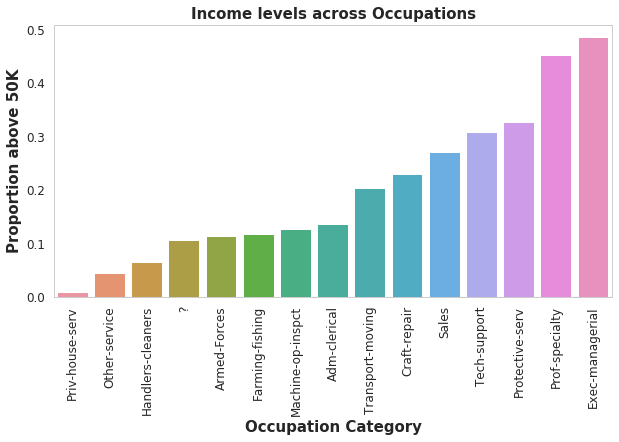

In [273]:
df_O=df_train.groupby("Occupation").mean("income_Target").sort(asc("avg(income_Target)")).toPandas()
fig5=plt.figure(figsize=(10,5))
ax1=fig5.add_subplot(1,1,1)
sns.barplot(x="Occupation",y='avg(income_Target)',data=df_O)
ax1.set_xlabel("Occupation Category",fontsize=15,weight='bold')
ax1.set_ylabel("Proportion above 50K",fontsize=15,weight='bold')
ax1.set_title("Income levels across Occupations",fontsize=15,weight='bold')
ax1.tick_params(axis="x",rotation=90)

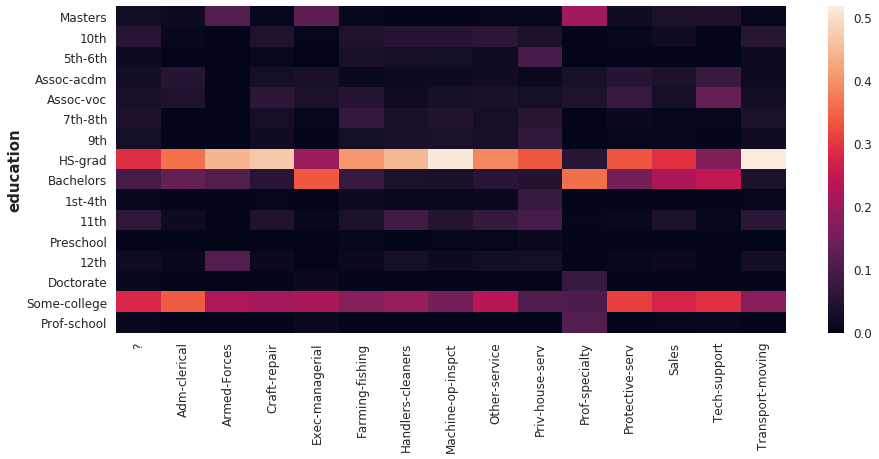

In [287]:
df_eo=df_train.groupby("education").pivot("Occupation").count().toPandas()
df_eo.set_index("education",inplace=True)
df_eo1=df_eo.apply(lambda x : x/x.sum(),axis=0)
df_eo1.replace(np.NaN,0,inplace=True)
fig9=plt.figure(figsize=(15,6))
ax1=fig9.add_subplot(1,1,1)
sns.heatmap(df_eo1,ax=ax1)

High school, bachelors and some college are major contributors to any of the professions.

** Relationship**

Text(0.5,1,u'Proportion of people above 50K')

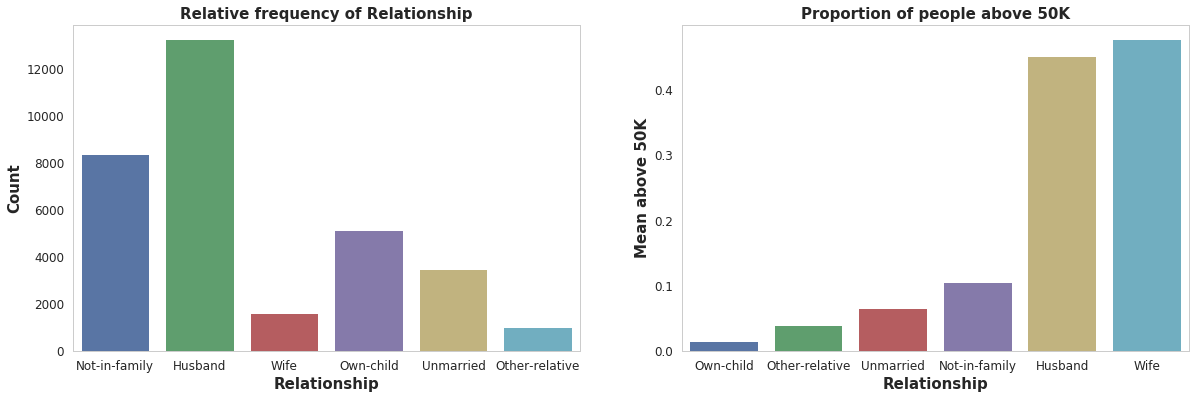

In [293]:
fig6=plt.figure(figsize=(20,6))
ax1=fig6.add_subplot(1,2,1)
df_r=df_train.select("relationship").toPandas()
sns.countplot(x="relationship",ax=ax1,data=df_r)
ax1.set_xlabel("Relationship",fontsize=15,weight='bold')
ax1.set_ylabel("Count",fontsize=15,weight='bold')
ax1.set_title("Relative frequency of Relationship",fontsize=15,weight='bold')
ax2=fig6.add_subplot(1,2,2)
df_r1=df_train.groupby("relationship").mean("income_Target").sort(avg("income_Target")).toPandas()
sns.barplot(x="relationship",y="avg(income_Target)",data=df_r1)
ax2.set_xlabel("Relationship",fontsize=15,weight='bold')
ax2.set_ylabel("Mean above 50K",fontsize=15,weight='bold')
ax2.set_title("Proportion of people above 50K",fontsize=15,weight='bold')

Married poeple have bigger proportion of people earning above 50K compared to unmarried. 

** Race **

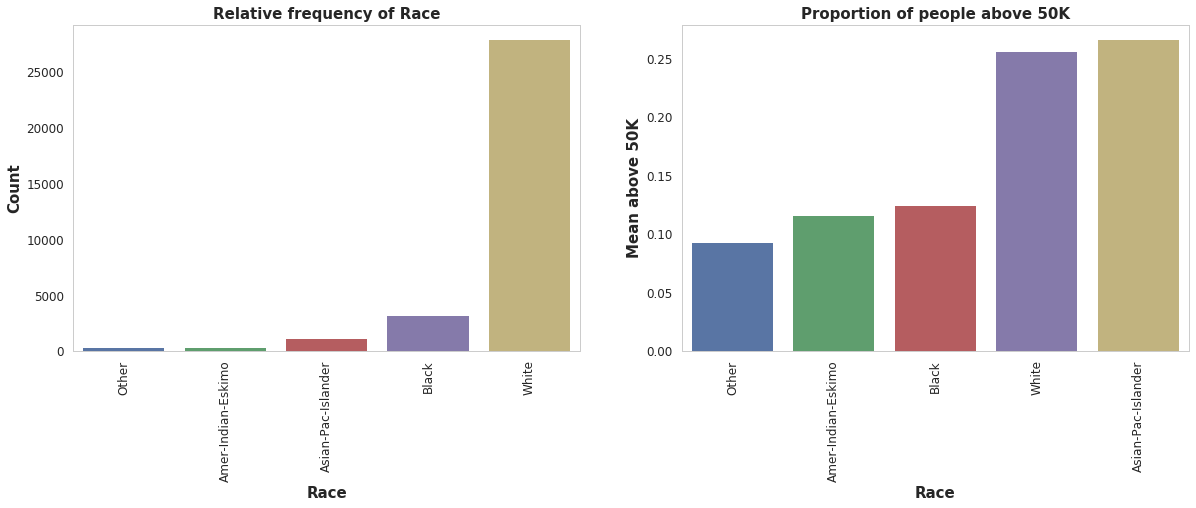

In [298]:
fig7=plt.figure(figsize=(20,6))
ax1=fig7.add_subplot(1,2,1)
df_ra=df_train.groupby("race").count().sort(asc("count")).toPandas()
sns.barplot(x="race",y="count",data=df_ra,ax=ax1)
ax1.set_xlabel("Race",fontsize=15,weight='bold')
ax1.set_ylabel("Count",fontsize=15,weight='bold')
ax1.set_title("Relative frequency of Race",fontsize=15,weight='bold')
ax1.tick_params(labelsize=12,axis='x',rotation=90)
ax2=fig7.add_subplot(1,2,2)
df_ra1=df_train.groupby("race").mean("income_Target").sort(avg("income_Target")).toPandas()
sns.barplot(x="race",y="avg(income_Target)",ax=ax2,data=df_ra1)
ax2.set_xlabel("Race",fontsize=15,weight='bold')
ax2.set_ylabel("Mean above 50K",fontsize=15,weight='bold')
ax2.set_title("Proportion of people above 50K",fontsize=15,weight='bold')
ax2.tick_params(labelsize=12,axis='x',rotation=90)

The data set has a huge chunk of white people. The proportion of people  earning above 50K is 0.25 for white people. Since
they are the major chunk, the over all average is also close to 0.25

** Sex **

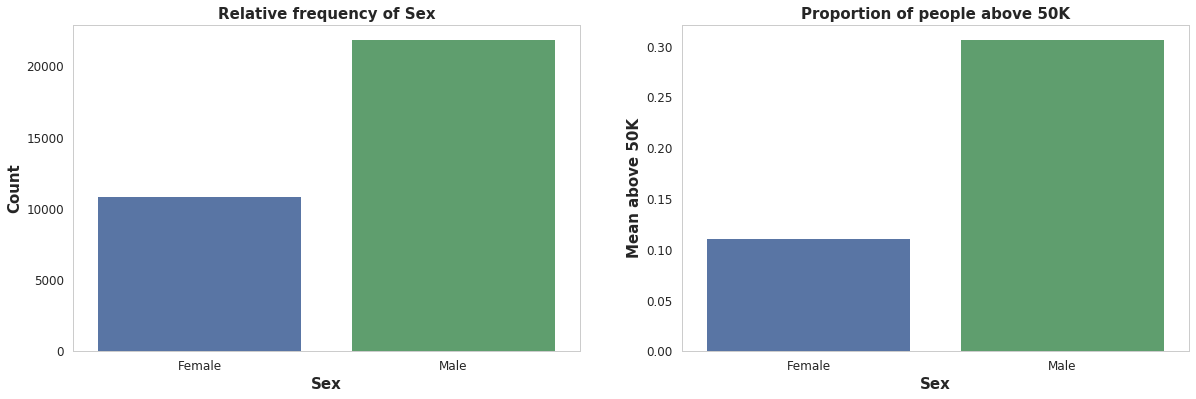

In [303]:
fig10=plt.figure(figsize=(20,6))
ax1=fig10.add_subplot(1,2,1)
df_s=df_train.groupby("sex").count().sort(asc("count")).toPandas()
sns.barplot(x="sex",y="count",data=df_s,ax=ax1)
ax1.set_xlabel("Sex",fontsize=15,weight='bold')
ax1.set_ylabel("Count",fontsize=15,weight='bold')
ax1.set_title("Relative frequency of Sex",fontsize=15,weight='bold')
ax1.tick_params(labelsize=12)
ax2=fig10.add_subplot(1,2,2)
df_ra1=df_train.groupby("sex").mean("income_Target").sort(avg("income_Target")).toPandas()
sns.barplot(x="sex",y="avg(income_Target)",data=df_ra1,ax=ax2)
ax2.set_xlabel("Sex",fontsize=15,weight='bold')
ax2.set_ylabel("Mean above 50K",fontsize=15,weight='bold')
ax2.set_title("Proportion of people above 50K",fontsize=15,weight='bold')
ax2.tick_params(labelsize=12)

Male to female ratio in the population is 2:1. Females have less earning potential than Male. This data will shed some light on 
education levels of female vs male , occupation an working class. But we will not explore them here

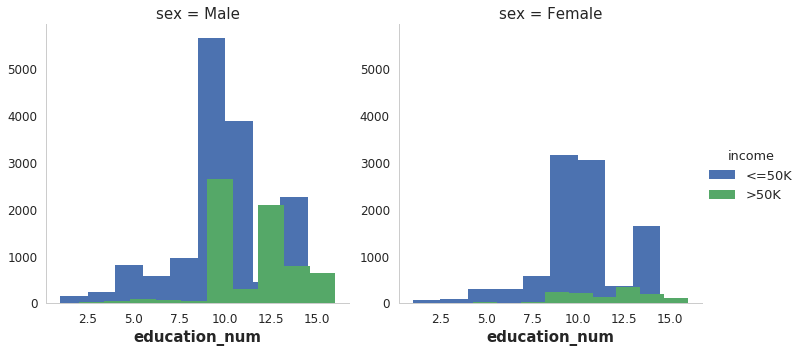

In [317]:
df_s=df_train.select("sex","education_num","income").toPandas()
g1=sns.FacetGrid(df_s,col='sex',hue='income',size=5)
g1.map(plt.hist,"education_num").add_legend()

In males, the proportion of people earning >50K suddenly falls after education_num 10 , increases at 12.5 then falls and increases at 15
15.

In females, the proportion picks up at 10 falls after it increases at 12.5 falls after that and increases at 15.

Not sure what is contributing to this cyclic nature, but it is worth investigating.

** Native Country **

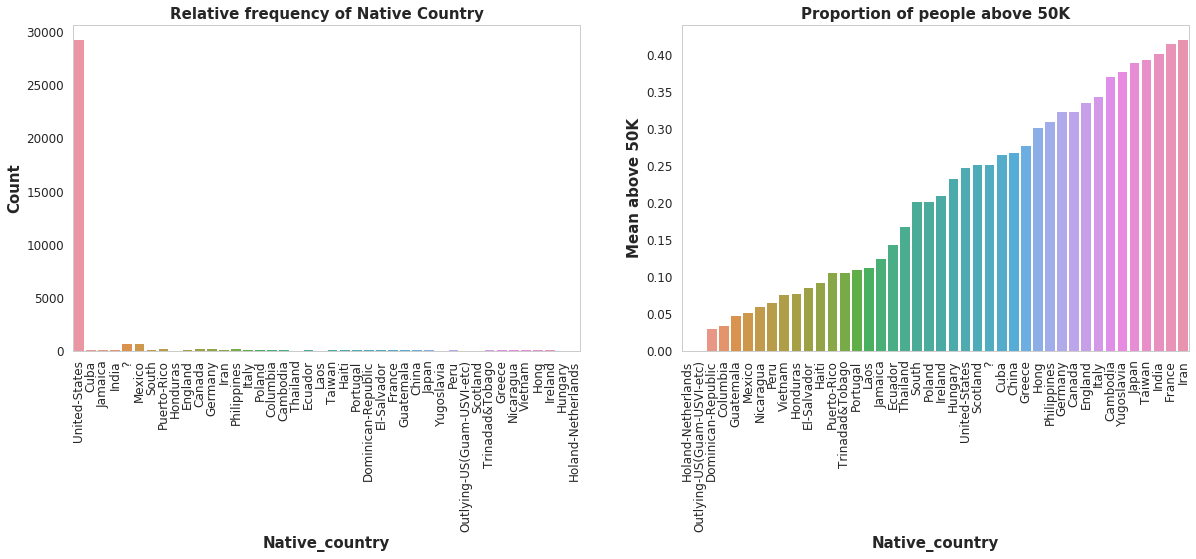

In [322]:
fig12=plt.figure(figsize=(20,6))
ax1=fig12.add_subplot(1,2,1)
df_s=df_train.select("native_country").toPandas()
sns.countplot(x="native_country",data=df_s,ax=ax1)
ax1.set_xlabel("Native_country",fontsize=15,weight='bold')
ax1.set_ylabel("Count",fontsize=15,weight='bold')
ax1.set_title("Relative frequency of Native Country",fontsize=15,weight='bold')
ax1.tick_params(labelsize=12,rotation=90,axis='x')
ax2=fig12.add_subplot(1,2,2)
df_ra1=df_train.groupby("native_country").mean("income_Target").sort(avg("income_Target")).toPandas()
sns.barplot(x="native_country",y="avg(income_Target)",data=df_ra1,ax=ax2)
ax2.set_xlabel("Native_country",fontsize=15,weight='bold')
ax2.set_ylabel("Mean above 50K",fontsize=15,weight='bold')
ax2.set_title("Proportion of people above 50K",fontsize=15,weight='bold')
ax2.tick_params(labelsize=12,rotation=90,axis='x')

The over all population is dominated by native americans.Iran ,France and Indian origin people have mean income higher than USA origin. Earlier in the analysis , we have seen that education levels have clear impact on earning potential. The interaction of
education with native country need to be studied to see if people from higher income countries have higher education levels
and occupations earning more income.

**fnlgwt**

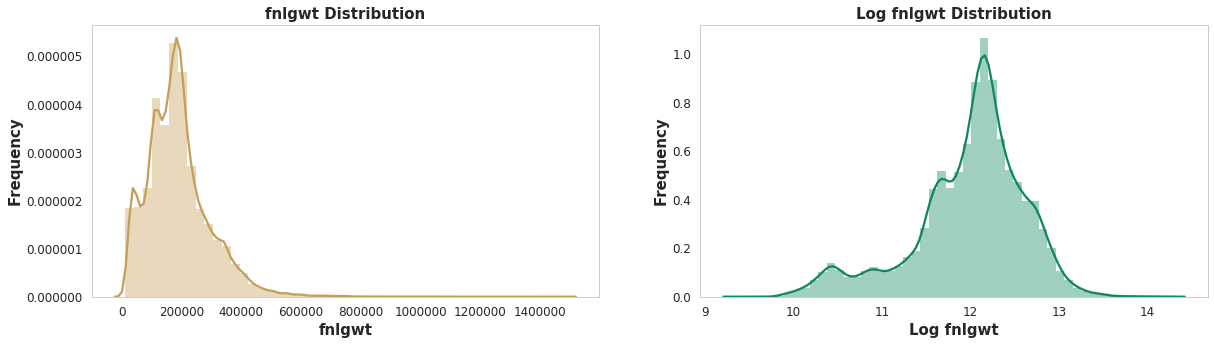

In [327]:
fig13=plt.figure(figsize=(20,5))
ax1=fig13.add_subplot(1,2,1)
df_fnlg=df_train.select("fnlgwt").toPandas()
sns.distplot(df_fnlg['fnlgwt'],bins=50,ax=ax1,color=sns.xkcd_rgb["camel"])
ax1.set_xlabel("fnlgwt",fontsize=15,weight='bold')
ax1.set_ylabel("Frequency",fontsize=15,weight='bold')
ax1.set_title("fnlgwt Distribution",fontsize=15,weight='bold')
ax1.tick_params(labelsize=12)
ax2=fig13.add_subplot(1,2,2)
df_fnlg2=df_train.select(log("fnlgwt").alias("age_log")).toPandas()
sns.distplot(df_fnlg2['age_log'],bins=50,ax=ax2,color=sns.xkcd_rgb["dark sea green"])
ax2.set_xlabel("Log fnlgwt",fontsize=15,weight='bold')
ax2.set_ylabel("Frequency",fontsize=15,weight='bold')
ax2.set_title("Log fnlgwt Distribution",fontsize=15,weight='bold')
ax2.tick_params(labelsize=12)

In [328]:
df_train.select(skewness(log("fnlgwt")).alias("log_Skewness")).collect()

[Row(log_Skewness=-0.8424414385371406)]

In [329]:
df_train.select(skewness("fnlgwt").alias("Skewness")).collect()

[Row(Skewness=1.4469134351423296)]

Normal distribution will have skweness close to zero.So, any dristribution having skewness close to zero is more normal . Taking
logarithm of fnlgwt changed the skewness from 1.44 to -0.84 . Even though the distribution changed from positive skew to negative
skew, the over absolute skewness changed interms of magnitude.

** Capital gain and Capital Loss**

In [330]:
pwf=udf(lambda x : math.pow(x,0.25),DoubleType())

Text(0.5,1,u'capital loss Distribution')

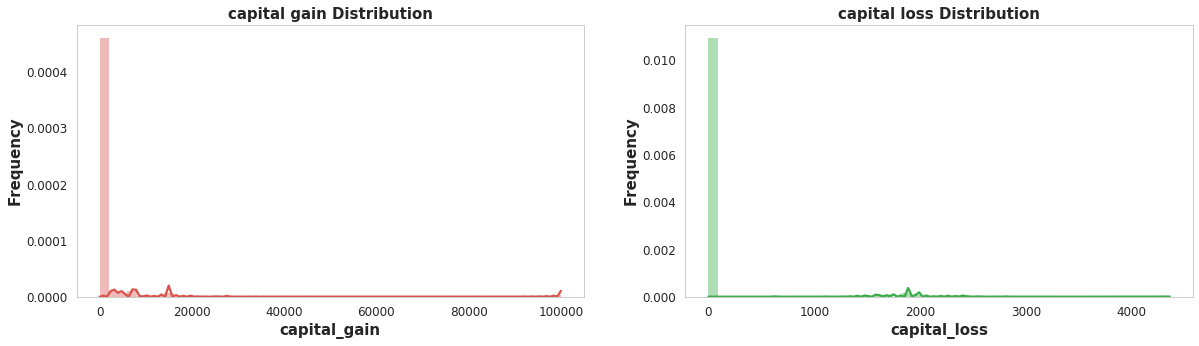

In [334]:
fig11=plt.figure(figsize=(20,5))
ax1=fig11.add_subplot(1,2,1)
df_cg=df_train.select("capital_gain").toPandas()
sns.distplot(df_cg['capital_gain'],bins=50,ax=ax1,color=sns.xkcd_rgb["pale red"])
ax1.set_xlabel("capital_gain",fontsize=15,weight='bold')
ax1.set_ylabel("Frequency",fontsize=15,weight='bold')
ax1.set_title("capital gain Distribution",fontsize=15,weight='bold')
ax2=fig11.add_subplot(1,2,2)
df_cl=df_train.select("capital_loss").toPandas()
sns.distplot(df_cl['capital_loss'],bins=50,ax=ax2,color=sns.xkcd_rgb["medium green"])
ax2.set_xlabel("capital_loss",fontsize=15,weight='bold')
ax2.set_ylabel("Frequency",fontsize=15,weight='bold')
ax2.set_title("capital loss Distribution",fontsize=15,weight='bold')


Capital gain and capital loss variables are higly skewed. No transformation will make them close to normal.

Most of the entries have capital gain and loss close to zero. But having non zero capital gain and loss can indicate the earning
potential of a person. 

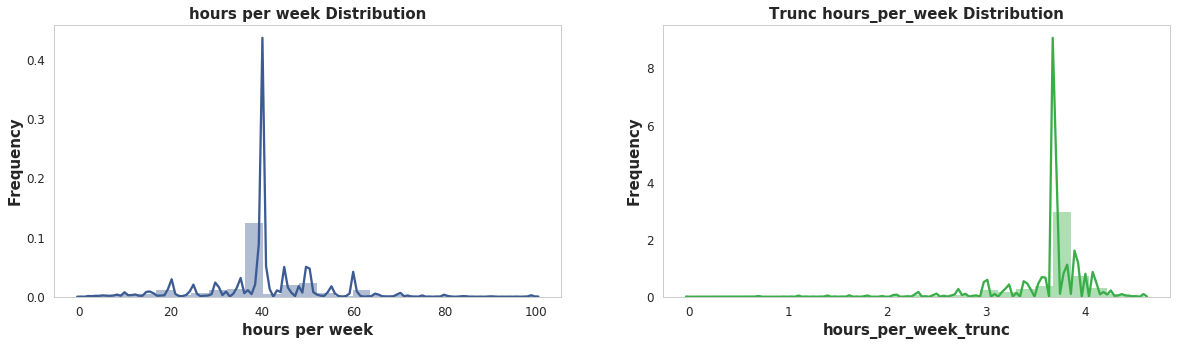

In [339]:
fig13=plt.figure(figsize=(20,5))
ax1=fig13.add_subplot(1,2,1)
df_h=df_train.select("hours_per_week").toPandas()
sns.distplot(df_h['hours_per_week'],bins=25,ax=ax1,color=sns.xkcd_rgb["denim blue"])
ax1.set_xlabel("hours per week",fontsize=15,weight='bold')
ax1.set_ylabel("Frequency",fontsize=15,weight='bold')
ax1.set_title("hours per week Distribution",fontsize=15,weight='bold')
ax1.tick_params(labelsize=12)
ax2=fig13.add_subplot(1,2,2)
df_hlog=df_train.select(log("hours_per_week").alias("log_hours_per_week")).toPandas()
sns.distplot(df_hlog['log_hours_per_week'],bins=25,ax=ax2,color=sns.xkcd_rgb["medium green"])
ax2.set_xlabel("hours_per_week_trunc",fontsize=15,weight='bold')
ax2.set_ylabel("Frequency",fontsize=15,weight='bold')
ax2.set_title("Trunc hours_per_week Distribution",fontsize=15,weight='bold')
ax2.tick_params(labelsize=12)

Hours per week has highest frequency at 40. This conincides with normal working hours of 40 per week. it is suprising to see some
people having working hours greater than 40. These working hours can be from people working in nor regulated industries such as
transportation and farming or fishing 

**correlation between numerical variables **

In [356]:
df_num=df_train.select("age","fnlgwt","education_num","capital_gain","capital_loss","hours_per_week")

In [357]:
vecasm=VectorAssembler(inputCols=['age','fnlgwt','education_num',"capital_gain",'capital_loss',"hours_per_week"],outputCol='features')

In [358]:
df_numv=vecasm.transform(df_num)

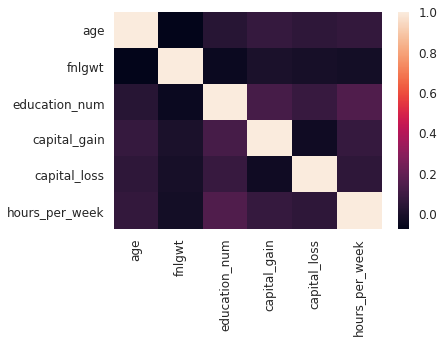

In [362]:
correlation=Correlation.corr(df_numv,"features","pearson").collect()[0][0]
correlation=correlation.toArray()
df_corr=pd.DataFrame(correlation,index=["age","fnlgwt","education_num","capital_gain","capital_loss","hours_per_week"],columns=["age","fnlgwt","education_num","capital_gain","capital_loss","hours_per_week"])
sns.heatmap(df_corr)

The correlation between numerical variables is very less